In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from dask import dataframe as dd
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()
from multiprocessing import cpu_count
import statsmodels.api as sm
import math
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
import scipy.stats as stats
from IPython.display import display
from IPython.core.debugger import set_trace as bp
import os
from statsmodels.tsa.stattools import adfuller

%matplotlib inline

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier
from sklearn.model_selection import train_test_split

import pyfolio as pf
from scipy import interp

C:\Users\Jay\lib\site-packages\pyfolio\pos.py:28: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  ' to position notionals.'


In [2]:
class FinancialFunctions:
    def __init__(self):
        pass

    @staticmethod
    def bbands(close_prices, window, no_of_stdev):
        # rolling_mean = close_prices.rolling(window=window).mean()
        # rolling_std = close_prices.rolling(window=window).std()
        rolling_mean = close_prices.ewm(span=window).mean()
        rolling_std = close_prices.ewm(span=window).std()

        upper_band = rolling_mean + (rolling_std * no_of_stdev)
        lower_band = rolling_mean - (rolling_std * no_of_stdev)

        return rolling_mean, upper_band, lower_band

    @staticmethod
    def relative_strength_index(df, n):
        """Calculate Relative Strength Index(RSI) for given data.
        https://github.com/Crypto-toolbox/pandas-technical-indicators/blob/master/technical_indicators.py
        
        :param df: pandas.DataFrame
        :param n: 
        :return: pandas.DataFrame
        """
        i = 0
        UpI = [0]
        DoI = [0]
        while i + 1 <= df.index[-1]:
            UpMove = df.loc[i + 1, 'high'] - df.loc[i, 'high']
            DoMove = df.loc[i, 'low'] - df.loc[i + 1, 'low']
            if UpMove > DoMove and UpMove > 0:
                UpD = UpMove
            else:
                UpD = 0
            UpI.append(UpD)
            if DoMove > UpMove and DoMove > 0:
                DoD = DoMove
            else:
                DoD = 0
            DoI.append(DoD)
            i = i + 1
        UpI = pd.Series(UpI)
        DoI = pd.Series(DoI)
        PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
        NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())
        RSI = pd.Series(round(PosDI * 100. / (PosDI + NegDI)), name='RSI_' + str(n))
        # df = df.join(RSI)
        return RSI

In [4]:
import numpy as np
import pandas as pd
from tqdm import tqdm
# from mlfinlab.util.multiprocess import MultiProcessingFunctions


class CoreFunctions:
    """ The class holds functions in Chapter 2 and 3 of AFML """

    def __init__(self):
        pass

    @staticmethod
    def get_daily_vol(close, lookback=100):
        """
        Snippet 3.1, page 44, Daily Volatility Estimates
        As argued in the previous section, in practice we want to set profit taking and stop-loss limits
        that are a function of the risks involved in a bet. Otherwise, sometimes we will be aiming
        too high (tao ≫ sigma_t_i,0), and sometimes too low (tao ≪ sigma_t_i,0 ), considering
        the prevailing volatility. Snippet 3.1 computes the daily volatility at intraday estimation points,
        applying a span of lookback days to an exponentially weighted moving standard deviation.
        See the pandas documentation for details on the pandas.Series.ewm function.
        Note: This function is used to compute dynamic thresholds for profit taking and stop loss limits.
        :param close: (data frame) Closing prices
        :param lookback: (int) lookback period to compute volatility
        :return: (series) of daily volatility value
        """
        print('Calculating daily volatility for dynamic thresholds')
        
        # daily vol re-indexed to close
        df0 = close.index.searchsorted(close.index - pd.Timedelta(days=1))
        df0 = df0[df0 > 0]
        df0 = (pd.Series(close.index[df0 - 1], index=close.index[close.shape[0] - df0.shape[0]:]))
        
        df0 = close.loc[df0.index] / close.loc[df0.values].values - 1  # daily returns
        df0 = df0.ewm(span=lookback).std()
        return df0

    @staticmethod
    def get_autocorr(close, lookback=100):
        """
        Daily Autocorr Estimates
        See the pandas documentation for details on the pandas.Series.ewm function.
        :param close: (data frame) Closing prices
        :param lookback: (int) lookback period to compute volatility
        :return: (series) of daily volatility value
        """
        print('Calculating Daily AutoCorr')

        # daily vol re-indexed to close
        df0 = close.index.searchsorted(close.index - pd.Timedelta(days=1))
        df0 = df0[df0 > 0]
        df0 = (pd.Series(close.index[df0 - 1], index=close.index[close.shape[0] - df0.shape[0]:]))

        df0 = close.loc[df0.index] / close.loc[df0.values].values - 1  # daily returns
        # df0 = df0.ewm(span=lookback).autocorr()
        df0 = df0.rolling(lookback).apply(lambda x: x.autocorr(), raw=False)
        return df0

    @staticmethod
    def get_t_events(raw_price, threshold):
        """
        Snippet 2.4, page 39, The Symmetric CUSUM Filter.
        The CUSUM filter is a quality-control method, designed to detect a shift in the
        mean value of a measured quantity away from a target value. The filter is set up to
        identify a sequence of upside or downside divergences from any reset level zero.
        We sample a bar t if and only if S_t >= threshold, at which point S_t is reset to 0.
        One practical aspect that makes CUSUM filters appealing is that multiple events are not
        triggered by gRaw hovering around a threshold level, which is a flaw suffered by popular
        market signals such as Bollinger Bands. It will require a full run of length threshold for 
        raw_price to trigger an event.
        Once we have obtained this subset of event-driven bars, we will let the ML algorithm determine
        whether the occurrence of such events constitutes actionable intelligence.
        Below is an implementation of the Symmetric CUSUM filter.
        :param raw_price: (series) of close prices.
        :param threshold: (float) when the abs(change) is larger than the threshold, the
        function captures it as an event.
        :return: (datetime index vector) vector of datetimes when the events occurred. This is used later to sample.
        """
        print('Applying Symmetric CUSUM filter.')

        t_events = []
        s_pos = 0
        s_neg = 0

        # log returns
        diff = np.log(raw_price).diff().dropna()

        # Get event time stamps for the entire series
        for i in tqdm(diff.index[1:]):
            pos = float(s_pos + diff.loc[i])
            neg = float(s_neg + diff.loc[i])
            s_pos = max(0.0, pos)
            s_neg = min(0.0, neg)

            if s_neg < -threshold:
                s_neg = 0
                t_events.append(i)

            elif s_pos > threshold:
                s_pos = 0
                t_events.append(i)

        event_timestamps = pd.DatetimeIndex(t_events)
        return event_timestamps

    @staticmethod
    def add_vertical_barrier(t_events, close, num_days=1):
        """
        Snippet 3.4 page 49, Adding a Vertical Barrier
        For each index in t_events, it finds the timestamp of the next price bar at or immediately after
        a number of days num_days. This vertical barrier can be passed as an optional argument t1 in get_events.
        This function creates a series that has all the timestamps of when the vertical barrier is reached.
        :param t_events: (series) series of events (symmetric CUSUM filter)
        :param close: (series) close prices
        :param num_days: (int) maximum number of days a trade can be active
        :return: (series) timestamps of vertical barriers
        """
        t1 = close.index.searchsorted(t_events + pd.Timedelta(days=num_days))
        t1 = t1[t1 < close.shape[0]]
        t1 = pd.Series(close.index[t1], index=t_events[:t1.shape[0]])  # NaNs at end
        return t1

    @staticmethod
    def apply_pt_sl_on_t1(close, events, pt_sl, molecule):
        """
        Snippet 3.2, page 45, Triple Barrier Labeling Method
        
        This function applies the triple-barrier labeling method. It works
        on a set of datetime index values (molecule). This allows the program
        to parallelize the processing.
        :param close: (series) close prices
        :param events: (series) of indices that signify "events" (see get_t_events function
        for more details)
        :param pt_sl: (array) element 0, indicates the profit taking level; element 1 is stop loss level
        :param molecule: (an array) a set of datetime index values for processing
        :return:
        """
        # apply stop loss/profit taking, if it takes place before t1 (end of event)
        events_ = events.loc[molecule]
        out = events_[['t1']].copy(deep=True)
        if pt_sl[0] > 0:
            pt = pt_sl[0] * events_['trgt']
        else:
            pt = pd.Series(index=events.index)  # NaNs

        if pt_sl[1] > 0:
            sl = -pt_sl[1] * events_['trgt']
        else:
            sl = pd.Series(index=events.index)  # NaNs

        for loc, t1 in events_['t1'].fillna(close.index[-1]).iteritems():
            df0 = close[loc:t1]  # path prices
            df0 = (df0 / close[loc] - 1) * events_.at[loc, 'side']  # path returns
            out.loc[loc, 'sl'] = df0[df0 < sl[loc]].index.min()  # earliest stop loss
            out.loc[loc, 'pt'] = df0[df0 > pt[loc]].index.min()  # earliest profit taking

        return out

    @staticmethod
    def get_events(close, t_events, pt_sl, target, min_ret, num_threads, vertical_barrier_times=False, side=None):
        """
        Snippet 3.6 page 50, Getting the Time of the First Touch, with Meta Labels
        This function is orchestrator to meta-label the data, in conjunction with the Triple Barrier Method.
        :param close: (series) Close prices
        :param t_events: (series) of t_events. These are timestamps that will seed every triple barrier.
            These are the timestamps selected by the sampling procedures discussed in Chapter 2, Section 2.5.
            Eg: CUSUM Filter
        :param pt_sl: (2 element array) element 0, indicates the profit taking level; element 1 is stop loss level.
            A non-negative float that sets the width of the two barriers. A 0 value means that the respective
            horizontal barrier (profit taking and/or stop loss) will be disabled.
        :param target: (series) of values that are used (in conjunction with pt_sl) to determine the width
            of the barrier. In this program this is daily volatility series.
        :param min_ret: (float) The minimum target return required for running a triple barrier search.
        :param num_threads: (int) The number of threads concurrently used by the function.
        :param vertical_barrier_times: (series) A pandas series with the timestamps of the vertical barriers.
            We pass a False when we want to disable vertical barriers.
        :param side: (series) Side of the bet (long/short) as decided by the primary model
        :return: (data frame) of events
                -events.index is event's starttime
                -events['t1'] is event's endtime
                -events['trgt'] is event's target
                -events['side'] (optional) implies the algo's position side
        """

        # 1) Get target
        target = target.loc[t_events]
        target = target[target > min_ret]  # min_ret

        # 2) Get vertical barrier (max holding period)
        if vertical_barrier_times is False:
            vertical_barrier_times = pd.Series(pd.NaT, index=t_events)

        # 3) Form events object, apply stop loss on vertical barrier
        if side is None:
            side_ = pd.Series(1., index=target.index)
            pt_sl_ = [pt_sl[0], pt_sl[0]]
        else:
            side_ = side.loc[target.index]
            pt_sl_ = pt_sl[:2]

        events = pd.concat({'t1': vertical_barrier_times, 'trgt': target, 'side': side_},
                           axis=1)
        events = events.dropna(subset=['trgt'])

        # Apply Triple Barrier
        df0 = MultiProcessingFunctions.mp_pandas_obj(func=CoreFunctions.apply_pt_sl_on_t1,
                                                     pd_obj=('molecule', events.index),
                                                     num_threads=num_threads,
                                                     close=close,
                                                     events=events,
                                                     pt_sl=pt_sl_)

        events['t1'] = df0.dropna(how='all').min(axis=1)  # pd.min ignores nan

        if side is None:
            events = events.drop('side', axis=1)

        return events

    @staticmethod
    def get_bins(triple_barrier_events, close):
        """
        Snippet 3.7, page 51, Labeling for Side & Size with Meta Labels
        Compute event's outcome (including side information, if provided).
        events is a DataFrame where:
        Now the possible values for labels in out['bin'] are {0,1}, as opposed to whether to take the bet or pass,
        a purely binary prediction. When the predicted label the previous feasible values {−1,0,1}.
        The ML algorithm will be trained to decide is 1, we can use the probability of this secondary prediction
        to derive the size of the bet, where the side (sign) of the position has been set by the primary model.
        :param triple_barrier_events: (data frame)
                    -events.index is event's starttime
                    -events['t1'] is event's endtime
                    -events['trgt'] is event's target
                    -events['side'] (optional) implies the algo's position side
                    Case 1: ('side' not in events): bin in (-1,1) <-label by price action
                    Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
        :param close: (series) close prices
        :return: (data frame) of meta-labeled events
        """

        # 1) Align prices with their respective events
        events_ = triple_barrier_events.dropna(subset=['t1'])
        prices = events_.index.union(events_['t1'].values)
        prices = prices.drop_duplicates()
        prices = close.reindex(prices, method='bfill')
        
        # 2) Create out DataFrame
        out_df = pd.DataFrame(index=events_.index)
        # Need to take the log returns, else your results will be skewed for short positions
        out_df['ret'] = np.log(prices.loc[events_['t1'].values].values) - np.log(prices.loc[events_.index])
        out_df['trgt'] = events_['trgt']

        # Meta labeling: Events that were correct will have pos returns
        if 'side' in events_:
            out_df['ret'] = out_df['ret'] * events_['side']  # meta-labeling

        # Added code: label 0 when vertical barrier reached
        out_df = CoreFunctions.barrier_touched(out_df)

        # Meta labeling: label incorrect events with a 0
        if 'side' in events_:
            out_df.loc[out_df['ret'] <= 0, 'bin'] = 0
        
        # Transform the log returns back to normal returns.
        out_df['ret'] = np.exp(out_df['ret']) - 1
        
        # Add the side to the output. This is useful for when a meta label model must be fit
        tb_cols = triple_barrier_events.columns
        if 'side' in tb_cols:
            out_df['side'] = triple_barrier_events['side']
            
        out_df

        return out_df

    @staticmethod
    def barrier_touched(out_df):
        """
        Snippet 3.9, pg 55, Question 3.3
        Adjust the getBins function (Snippet 3.7) to return a 0 whenever the vertical barrier is the one touched first.
        Top horizontal barrier: 1
        Bottom horizontal barrier: -1
        Vertical barrier: 0
        :param out_df: (DataFrame) containing the returns and target
        :return: (DataFrame) containing returns, target, and labels
        """
        store = []
        for i in np.arange(len(out_df)):
            date_time = out_df.index[i]
            ret = out_df.loc[date_time, 'ret']
            target = out_df.loc[date_time, 'trgt']

            if ret > 0.0 and ret > target:
                # Top barrier reached
                store.append(1)
            elif ret < 0.0 and ret < -target:
                # Bottom barrier reached
                store.append(-1)
            else:
                # Vertical barrier reached
                store.append(0)

        out_df['bin'] = store

        return out_df

    @staticmethod
    def drop_labels(events, min_pct=.05):
        """ The function recursively eliminates rare observations.
        Snippet 3.8 page 54
        :param events: (data frame) events
        :param min_pct: (float) a fraction used to decide if the observation occurs less than
        that fraction
        :return: (data frame) of events
        """
        # apply weights, drop labels with insufficient examples
        while True:
            df0 = events['bin'].value_counts(normalize=True)

            if df0.min() > min_pct or df0.shape[0] < 3:
                break

            print('dropped label: ', df0.argmin(), df0.min())
            events = events[events['bin'] != df0.argmin()]

        return events

In [3]:
import sys
import time
import numpy as np
import pandas as pd
import datetime as dt
import multiprocessing as mp


class MultiProcessingFunctions:
	""" This static functions in this class enable multi-processing"""
	def __init__(self):
		pass

	@staticmethod
	def lin_parts(num_atoms, num_threads):
		""" This function partitions a list of atoms in subsets (molecules) of equal size.
		An atom is a set of indivisible set of tasks.
		Reference: Snippet 20.6 (page 308)
		"""

		# partition of atoms with a single loop
		parts = np.linspace(0, num_atoms, min(num_threads, num_atoms) + 1)
		parts = np.ceil(parts).astype(int)
		return parts

	@staticmethod
	def nested_parts(num_atoms, num_threads, upper_triangle=False):
		""" This function enables parallelization of nested loops.
		Reference: Snippet 20.5 (page 306)
		"""
		# partition of atoms with an inner loop
		parts = []
		num_threads_ = min(num_threads, num_atoms)

		for num in range(num_threads_):
			part = 1 + 4 * (parts[-1] ** 2 + parts[-1] + num_atoms * (num_atoms + 1.) / num_threads_)
			part = (-1 + part ** .5) / 2.
			parts.append(part)

		parts = np.round(parts).astype(int)

		if upper_triangle:  # the first rows are heaviest
			parts = np.cumsum(np.diff(parts)[::-1])
			parts = np.append(np.array([0]), parts)
		return parts

	@staticmethod
	def mp_pandas_obj(func, pd_obj, num_threads=24, mp_batches=1, lin_mols=True, **kargs):
		"""	Parallelize jobs, return a dataframe or series
		Example: df1=mp_pandas_obj(func,('molecule',df0.index),24,**kwds)
		Reference: Snippet 20.7 (page 310)
		:param func: (string) function to be parallelized
		:param pd_obj: (vector) Element 0, is name of argument used to pass the molecule;
						Element 1, is the list of atoms to be grouped into a molecule
		:param num_threads: (int) number of threads
		:param mp_batches: (int) number of batches
		:param lin_mols: (bool) Tells if the method should use linear or nested partitioning
		:param kargs: (var args)
		:return: (data frame) of results
		"""

		if lin_mols:
			parts = MultiProcessingFunctions.lin_parts(len(pd_obj[1]), num_threads * mp_batches)
		else:
			parts = MultiProcessingFunctions.nested_parts(len(pd_obj[1]), num_threads * mp_batches)

		jobs = []
		for i in range(1, len(parts)):
			job = {pd_obj[0]: pd_obj[1][parts[i - 1]:parts[i]], 'func': func}
			job.update(kargs)
			jobs.append(job)

		if num_threads == 1:
			out = MultiProcessingFunctions.process_jobs_(jobs)
		else:
			out = MultiProcessingFunctions.process_jobs(jobs, num_threads=num_threads)

		if isinstance(out[0], pd.DataFrame):
			df0 = pd.DataFrame()
		elif isinstance(out[0], pd.Series):
			df0 = pd.Series()
		else:
			return out

		for i in out:
			df0 = df0.append(i)

		df0 = df0.sort_index()
		return df0

	@staticmethod
	def process_jobs_(jobs):
		""" Run jobs sequentially, for debugging """
		out = []
		for job in jobs:
			out_ = MultiProcessingFunctions.expand_call(job)
			out.append(out_)
		return out

	@staticmethod
	def expand_call(kargs):
		""" Expand the arguments of a callback function, kargs['func'] """
		func = kargs['func']
		del kargs['func']
		out = func(**kargs)
		return out

	@staticmethod
	def report_progress(job_num, num_jobs, time0, task):
		# Report progress as asynch jobs are completed

		msg = [float(job_num) / num_jobs, (time.time() - time0)/60.]
		msg.append(msg[1] * (1/msg[0] - 1))
		time_stamp = str(dt.datetime.fromtimestamp(time.time()))

		msg = time_stamp + ' ' + str(round(msg[0]*100, 2)) + '% '+task+' done after ' + \
			str(round(msg[1], 2)) + ' minutes. Remaining ' + str(round(msg[2], 2)) + ' minutes.'

		if job_num < num_jobs:
			sys.stderr.write(msg+'\r')
		else:
			sys.stderr.write(msg+'\n')

		return

	@staticmethod
	def process_jobs(jobs, task=None, num_threads=24):
		""" Run in parallel. jobs must contain a 'func' callback, for expand_call"""

		if task is None:
			task = jobs[0]['func'].__name__

		pool = mp.Pool(processes=num_threads)
		# outputs, out, time0 = pool.imap_unordered(MultiProcessingFunctions.expand_call,jobs),[],time.time()
		outputs = pool.imap_unordered(MultiProcessingFunctions.expand_call, jobs)
		out = []
		time0 = time.time()

		# Process asyn output, report progress
		for i, out_ in enumerate(outputs, 1):
			out.append(out_)
			MultiProcessingFunctions.report_progress(i, len(jobs), time0, task)

		pool.close()
		pool.join()  # this is needed to prevent memory leaks
		return out

In [9]:
def mpPandasObj(func,pdObj,numThreads=1,mpBatches=1,linMols=True,**kargs):
    '''
    Parallelize jobs, return a dataframe or series
    + func: function to be parallelized. Returns a DataFrame
    + pdObj[0]: Name of argument used to pass the molecule
    + pdObj[1]: List of atoms that will be grouped into molecules
    + kwds: any other argument needed by func
    Example: df1=mpPandasObj(func,('molecule',df0.index),24,**kwds)
    '''
    import pandas as pd
    #if linMols:parts=linParts(len(argList[1]),numThreads*mpBatches)
    #else:parts=nestedParts(len(argList[1]),numThreads*mpBatches)
    if linMols:parts=linParts(len(pdObj[1]),numThreads*mpBatches)
    else:parts=nestedParts(len(pdObj[1]),numThreads*mpBatches)

    jobs=[]
    for i in range(1,len(parts)):
        job={pdObj[0]:pdObj[1][parts[i-1]:parts[i]],'func':func}
        job.update(kargs)
        jobs.append(job)
    if numThreads==1:out=processJobs_(jobs)
    else: out=processJobs(jobs,numThreads=numThreads)
    if isinstance(out[0],pd.DataFrame):df0=pd.DataFrame()
    elif isinstance(out[0],pd.Series):df0=pd.Series()
    else:return out
    for i in out:df0=df0.append(i)
    df0=df0.sort_index()
    return df0

def mpNumCoEvents(closeIdx,t1,molecule):
    '''
    Compute the number of concurrent events per bar.
    +molecule[0] is the date of the first event on which the weight will be computed
    +molecule[-1] is the date of the last event on which the weight will be computed
    Any event that starts before t1[modelcule].max() impacts the count.
    '''
    #1) find events that span the period [molecule[0],molecule[-1]]
    t1=t1.fillna(closeIdx[-1]) # unclosed events still must impact other weights
    t1=t1[t1>=molecule[0]] # events that end at or after molecule[0]
    t1=t1.loc[:t1[molecule].max()] # events that start at or before t1[molecule].max()
    #2) count events spanning a bar
    iloc=closeIdx.searchsorted(np.array([t1.index[0],t1.max()]))
    count=pd.Series(0,index=closeIdx[iloc[0]:iloc[1]+1])
    for tIn,tOut in t1.iteritems():count.loc[tIn:tOut]+=1.
    return count.loc[molecule[0]:t1[molecule].max()]

def linParts(numAtoms,numThreads):
    # partition of atoms with a single loop
    parts=np.linspace(0,numAtoms,min(numThreads,numAtoms)+1)
    parts=np.ceil(parts).astype(int)
    return parts

def processJobs_(jobs):
    # Run jobs sequentially, for debugging
    out=[]
    for job in jobs:
        out_=expandCall(job)
        out.append(out_)
    return out
def expandCall(kargs):
    # Expand the arguments of a callback function, kargs['func']
    func=kargs['func']
    del kargs['func']
    out=func(**kargs)
    return out
def mpSampleW(t1,numCoEvents,close,molecule):
    # Derive sample weight by return attribution
    ret=np.log(close).diff() # log-returns, so that they are additive
    wght=pd.Series(index=molecule)
    for tIn,tOut in t1.loc[wght.index].iteritems():
        wght.loc[tIn]=(ret.loc[tIn:tOut]/numCoEvents.loc[tIn:tOut]).sum()
    return wght.abs()


def get_weight_ffd(differencing_amt, threshold, weight_vector_len):
    """
    Source: Chapter 5, AFML (section 5.4.2)
    The helper function generates weights that are used to compute fractionally differentiated series.
    :param differencing_amt: (double) a amt (fraction) by which the series is differenced
    :param threshold: (double) used to discard weights that are less than the threshold
    :param weight_vector_len: (int) length of teh vector to be generated
    :return: (np.array) weights vector
    """
    weights = [1.]
    k = 1
    ctr = 0
    while True:
        weight_ = -weights[-1] / k * (differencing_amt - k + 1)
        if abs(weight_) < threshold:
            break
        weights.append(weight_)
        k += 1
        ctr += 1
        if ctr == weight_vector_len - 1:
            break
    weights = np.array(weights[::-1]).reshape(-1, 1)
    return weights

def frac_diff_ffd(price_series, differencing_amt, threshold=1e-5):
    """
    Source: Chapter 5, AFML (section 5.5);
    Source code: https://github.com/philipperemy/fractional-differentiation-time-series
    References:
    https://www.wiley.com/en-us/Advances+in+Financial+Machine+Learning-p-9781119482086
    https://wwwf.imperial.ac.uk/~ejm/M3S8/Problems/hosking81.pdf
    https://en.wikipedia.org/wiki/Fractional_calculus
    The steps are as follows:
    - Compute weights (this is a one-time exercise)
    - Iteratively apply the weights to the price series and generate output points
    :param price_series: (series) of prices.  These could be raw prices or log of prices
    :param differencing_amt: (double) a amt (fraction) by which the series is differenced
    :param threshold:  (double) used to discard weights that are less than the threshold
    :return: (np.array) fractionally differenced series
    """

    # compute weights for the longest series
    weights = get_weight_ffd(differencing_amt, threshold, len(price_series))
    width = len(weights) - 1

    # apply weights to values
    output = []
    output.extend([0] * width)
    for i in range(width, len(price_series)):
        output.append(np.dot(weights.T, price_series[i - width:i + 1])[0])
    return np.array(output)

def compare_adf_stat_with_critical_values(result):
    """ Function compares the t-stat with adfuller critcial values (1%) and returnsm true or false
        depending on if the t-stat >= adfuller critical value
        :result (dict_items) Output from adfuller test
        :return (bool)
    """
    tstat = abs(next(iter(result[4].items()))[1])
    adf_stat = abs(round(result[0], 3))
    if adf_stat >= tstat:
        return True
    else:
        return False
    
def compute_differencing_amt(price_series, threshold=1e-5):
    """ Function iterates over the differencing amounts and computes the smallest amt that will make the 
        series stationary
        :price_series (pd.Series) price series
        :threshold (float) pass-thru to fracdiff function
        :return (float) differencing amount 
    """
    test_range = np.arange(0.0, 1., 0.05)
    found = False
    i = 0
    while not found:
        fracs = frac_diff_ffd(price_series.apply(np.log), differencing_amt=test_range[i], threshold=threshold)
        result = adfuller(fracs, maxlag=2, regression='C', autolag='AIC', store=False, regresults=False)
        if compare_adf_stat_with_critical_values(result):
            if i > 0 and i < len(test_range):
                test_narrow_range = np.arange(test_range[i-1], test_range[i+1], 0.01)
                found = False
                j = 0
                while not found:
                    fracs = frac_diff_ffd(price_series.apply(np.log), differencing_amt=test_narrow_range[j], threshold=threshold)
                    result = adfuller(fracs, maxlag=2, regression='C', autolag='AIC', store=False, regresults=False)
                    if compare_adf_stat_with_critical_values(result):
                        found = True
                        diff_amt = test_narrow_range[j]
                    else:
                        j += 1
            elif i == 0:
                found = True
                diff_amt = test_range[i+1]
            else:
                found = True
                diff_amt = test_range[len(test_range)]
        else: 
            i += 1
    if not found:
        diff_amt = 1.0
        
    return diff_amt


def getTrainTimes(t1,testTimes):
    """
    Given testTimes, find the times of the training observations
    -t1.index: Time when the observation started
    -t1.value: Time when the observation ended
    -testTimes: Times of testing observations
    """
    trn=t1.copy(deep=True)
    for i,j in testTimes.iteritems():
        df0=trn[(i<=trn.index)&(trn.index<=j)].index # train starts within test
        df1=trn[(i<=trn)&(trn<=j)].index # train ends within test
        df2=trn[(trn.index<=i)&(j<=trn)].index # train envelops test
        trn=trn.drop(df0.union(df1).union(df2))
    return trn

def getEmbargoTimes(times,pctEmbargo):
    # Get embargo time for each bar
    step=int(times.shape[0]*pctEmbargo)
    if step==0:
        mbrg=pd.Series(times,index=times)
    else:
        mbrg=pd.Series(times[step:],index=times[:-step])
        mbrg=mbrg.append(pd.Series(times[-1],index=times[-step:]))
    return mbrg


from sklearn.model_selection._split import _BaseKFold
class PurgedKFold(_BaseKFold):
    """
    Extend KFold class to work with labels that span intervals
    The train is purged of observations overlapping test-label intervals
    Test set is assumed contiguous (shuffle=False), w/o training samples in between
    """
    def __init__(self,n_splits=3,t1=None,pctEmbargo=0.):
        if not isinstance(t1,pd.Series):
            raise ValueError('Label Through Dates must be a pd.Series')
        super(PurgedKFold,self).__init__(n_splits,shuffle=False,random_state=None)
        self.t1=t1
        self.pctEmbargo=pctEmbargo
        
    def split(self,X,y=None,groups=None):
        if (X.index==self.t1.index).sum()!=len(self.t1):
            raise ValueError('X and ThruDateValues must have the same index')
        indices=np.arange(X.shape[0])
        mbrg=int(X.shape[0]*self.pctEmbargo)
        test_starts=[
            (i[0],i[-1]+1) for i in np.array_split(np.arange(X.shape[0]),
                                                   self.n_splits)
        ]
        for i,j in test_starts:
            t0=self.t1.index[i] # start of test set
            test_indices=indices[i:j]
            maxT1Idx=self.t1.index.searchsorted(self.t1[test_indices].max())
            train_indices=self.t1.index.searchsorted(self.t1[self.t1<=t0].index)
            if maxT1Idx<X.shape[0]: # right train ( with embargo)
                train_indices=np.concatenate((train_indices, indices[maxT1Idx+mbrg:]))
            yield train_indices,test_indices
            
def cvScore(clf,X,y,sample_weight,scoring='neg_log_loss',
            t1=None,cv=None,cvGen=None,pctEmbargo=None):
    if scoring not in ['neg_log_loss','accuracy']:
        raise Exception('wrong scoring method.')
    from sklearn.metrics import log_loss,accuracy_score
    idx = pd.IndexSlice
    if cvGen is None:
        cvGen=PurgedKFold(n_splits=cv,t1=t1,pctEmbargo=pctEmbargo) # purged
    score=[]
    for train,test in cvGen.split(X=X):
        fit=clf.fit(X=X.iloc[idx[train],:],y=y.iloc[idx[train]],
                    sample_weight=sample_weight.iloc[idx[train]].values)
        if scoring=='neg_log_loss':
            prob=fit.predict_proba(X.iloc[idx[test],:])
            score_=-log_loss(y.iloc[idx[test]], prob,
                                    sample_weight=sample_weight.iloc[idx[test]].values,
                                    labels=clf.classes_)
        else:
            pred=fit.predict(X.iloc[idx[test],:])
            score_=accuracy_score(y.iloc[idx[test]],pred,
                                  sample_weight=sample_weight.iloc[idx[test]].values)
        score.append(score_)
    return np.array(score)

from sklearn.model_selection import StratifiedKFold


def crossValPlot(skf,classifier,X_,y_):
    """Code adapted from:
        
    """
    
    X = np.asarray(X_)
    y = np.asarray(y_)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    f,ax = plt.subplots(figsize=(10,7))
    i = 0
    for train, test in skf.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    ax.legend(bbox_to_anchor=(1,1))
    
def crossValPlot2(skf,classifier,X,y):
    """Code adapted from:
        
    """
    from itertools import cycle
    from sklearn.metrics import roc_curve, auc
    from scipy import interp
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    idx = pd.IndexSlice
    f,ax = plt.subplots(figsize=(10,7))
    i = 0
    for train, test in skf.split(X, y):
        probas_ = (classifier.fit(X.iloc[idx[train]], y.iloc[idx[train]])
                   .predict_proba(X.iloc[idx[test]]))
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[idx[test]], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    ax.legend(bbox_to_anchor=(1,1))
    
def get_rsi(data, window=14):
    df = data.copy(deep=True).reset_index()
    rsi = FinancialFunctions.relative_strength_index(df, window)
    rsi_df = pd.Series(data=rsi.values, index=data.index)
    return rsi_df

## - Read Data

In [6]:
data = pd.DataFrame(columns=['date_time', 'open', 'high', 'low', 'close', 'cum_vol', 'cum_dollar', 'cum_ticks'])

for i in os.listdir('C:/Users/win/Desktop/afml/dollar_bar_data_233740/'):
    dollar_bar = pd.read_csv('C:/Users/win/Desktop/afml/dollar_bar_data_233740/' + i)
    data = pd.concat([data, dollar_bar], axis=0).reset_index(drop=True)

data = data.sort_values(by='date_time').reset_index(drop=True)
data = data.set_index('date_time')
# data.index=pd.to_datetime(data['date_time'])
# data = data.drop('date_time', axis=1)
df = data.loc[:'2018-10-01'].copy(deep=True)
close = data['close'].loc[:'2018-10-01']
data.head()

,open,high,low,close,cum_vol,cum_dollar,cum_ticks
date_time,,,,,,,
20180917 09:00:30.513028,18390.0,18395.0,18390.0,18395.0,1787,32869550.0,9
20180917 09:00:34.830220,18395.0,18395.0,18385.0,18390.0,3344,61491455.0,17
20180917 09:00:34.830627,18390.0,18390.0,18390.0,18390.0,2001,36798390.0,1
20180917 09:00:34.832177,18390.0,18390.0,18390.0,18390.0,1666,30637740.0,2
20180917 09:00:34.839976,18390.0,18390.0,18390.0,18390.0,2450,45055500.0,6


## - Create Features
- 1) Bollinger Bands (Primary Model)
- 2) FracDiff
- 3) RSI

In [7]:
# 1) Bollinger Bands Feature
window = 50 
data['avg'], data['upper'], data['lower'] = FinancialFunctions.bbands(data['close'], window, no_of_stdev=1.5)
print(data.head())

                             open     high      low    close cum_vol  \
date_time                                                              
20180917 09:00:30.513028  18390.0  18395.0  18390.0  18395.0    1787   
20180917 09:00:34.830220  18395.0  18395.0  18385.0  18390.0    3344   
20180917 09:00:34.830627  18390.0  18390.0  18390.0  18390.0    2001   
20180917 09:00:34.832177  18390.0  18390.0  18390.0  18390.0    1666   
20180917 09:00:34.839976  18390.0  18390.0  18390.0  18390.0    2450   

                          cum_dollar cum_ticks           avg         upper  \
date_time                                                                    
20180917 09:00:30.513028  32869550.0         9  18395.000000           NaN   
20180917 09:00:34.830220  61491455.0        17  18392.450000  18397.753301   
20180917 09:00:34.830627  36798390.0         1  18391.600453  18395.886775   
20180917 09:00:34.832177  30637740.0         2  18391.176020  18394.850285   
20180917 09:00:34.839976  4

In [8]:
# 2) FracDiff Feature
diff_amt = compute_differencing_amt(data['close'])
print('Differening amount: {:.3f}'.format(diff_amt))
fracs = frac_diff_ffd(np.log(data['close']), differencing_amt = diff_amt, threshold=1e-5)
frac_df = pd.Series(data=fracs, index=data.index)
frac_df.tail()
data['fracdiff'] = [frac_df[x] for x in data.index]

Differening amount: 0.010


In [10]:
# 3) RSI Feature
rsi_windows = [5, 13, 34, 55]
for w in rsi_windows:
    rsi = get_rsi(data, window=w).squeeze()
    data[f'rsi_{w}'] = rsi

data.dropna(inplace=True)
print(data)

                             open     high      low    close cum_vol  \
date_time                                                              
20180917 09:02:04.842751  18365.0  18370.0  18360.0  18360.0    4888   
20180917 09:02:05.949621  18360.0  18365.0  18355.0  18355.0    2936   
20180917 09:02:06.138248  18355.0  18365.0  18355.0  18365.0    2999   
20180917 09:02:11.231040  18365.0  18375.0  18365.0  18365.0    2149   
20180917 09:02:12.558239  18365.0  18370.0  18355.0  18355.0    3719   
20180917 09:02:12.653246  18355.0  18370.0  18350.0  18370.0    1706   
20180917 09:02:26.194241  18370.0  18375.0  18350.0  18355.0    2157   
20180917 09:02:27.024010  18355.0  18355.0  18350.0  18350.0    1743   
20180917 09:02:27.025747  18350.0  18345.0  18335.0  18335.0    1732   
20180917 09:02:27.028713  18335.0  18330.0  18320.0  18320.0    4045   
20180917 09:02:27.029773  18320.0  18315.0  18315.0  18315.0    3531   
20180917 09:02:27.031038  18315.0  18310.0  18310.0  18310.0    

[677325 rows x 15 columns]


## - Fit Primary model (1. Bollinger Band Model)
- Bollinger Band was used to "bet" on "Long" or "Short"

In [40]:
# Compute Sides
data['side'] = np.nan

long_signals = (data['close'] <= data['lower']) 
short_signals = (data['close'] > data['upper'])

data.loc[long_signals, 'side'] = 1
data.loc[short_signals, 'side'] = -1

print(data.side.value_counts())

data['side'] = data['side'].shift(1)

 1.0    32520
-1.0    28021
Name: side, dtype: int64


In [42]:
# save the raw data
# deleted nan values
raw_data = data.copy()
data.index = pd.to_datetime(data.index)
data.dropna(axis=0, how='any', inplace=True)

In [44]:
close = data['close']
daily_vol = CoreFunctions.get_daily_vol(close=close, lookback=50)

Calculating daily volatility for dynamic thresholds


In [45]:
cusum_events = CoreFunctions.get_t_events(close, threshold=daily_vol.mean()*0.5)

Applying Symmetric CUSUM filter.


100%|█████████████████████████████████████████████████████████████████████████| 60539/60539 [00:03<00:00, 17212.89it/s]


In [46]:
vertical_barriers = CoreFunctions.add_vertical_barrier(t_events=cusum_events, 
                                                       close=close, num_days=1)

In [49]:
pt_sl = [1, 2]
min_ret = 0.005
triple_barrier_events = CoreFunctions.get_events(close=close,
                                  t_events=cusum_events,
                                  pt_sl=pt_sl,
                                  target=daily_vol,
                                  min_ret=min_ret,
                                  num_threads=1,
                                  vertical_barrier_times=vertical_barriers,
                                  side=data['side'])

labels = CoreFunctions.get_bins(triple_barrier_events, data['close'])
labels.side.value_counts()

 1.0    1830
-1.0    1730
Name: side, dtype: int64

## - Add More Features to raw_data.
- Why?

In [57]:
raw_data['log_ret'] = np.log(raw_data['close']).diff()

# momentum
for w in rsi_windows:
    raw_data[f'mom_{w}'] = raw_data['close'].pct_change(w)

# vol
for w in rsi_windows:
    raw_data[f'vol_{w}'] = (raw_data['log_ret']
                            .rolling(window=w, min_periods=w, center=False)
                            .std())
    
# autocorr
window_autocorr = 50
raw_data['autocorr_1'] = (raw_data['log_ret'].rolling(window=window_autocorr,
                                                     min_periods=window_autocorr, center=False)
                         .apply(lambda x: x.autocorr(lag=1), raw=False))

# fast and slow mavg
# add fast and slow moving averages
fast_window = 7
slow_window = 15

raw_data['fast_mavg'] = (raw_data['close'].rolling(window=fast_window,
                                                  min_periods=fast_window, center=False).mean())
raw_data['slow_mavg'] = (raw_data['close'].rolling(window=slow_window,
                                                  min_periods=slow_window, center=False).mean())

In [58]:
# Add Trending Signal
raw_data['sma'] = np.nan

long_signals = raw_data['fast_mavg'] >= raw_data['slow_mavg']
short_signals = raw_data['fast_mavg'] < raw_data['slow_mavg']
raw_data.loc[long_signals, 'sma'] = 1
raw_data.loc[short_signals, 'sma'] = -1

In [60]:
# Re-Compute the original sides
raw_data['side'] = np.nan

long_signals = (raw_data['close'] <= raw_data['lower']) 
short_signals = (raw_data['close'] >= raw_data['upper']) 

raw_data.loc[long_signals, 'side'] = 1
raw_data.loc[short_signals, 'side'] = -1

print(raw_data.side.value_counts())

 1.0    32520
-1.0    28021
Name: side, dtype: int64


In [61]:
# Remove Look ahead bias by lagging the signal
raw_data['side'] = raw_data['side'].shift(1)

In [63]:
# drop nan values from the raw_data set
raw_data.index = pd.to_datetime(raw_data.index)
raw_data.dropna(axis=0, how='any', inplace=True)

## - Extract Data when the events were occured

In [64]:
# Get Features at event dates 
X = raw_data.loc[labels.index, :]
X = X.fillna(0)

# Drop unwanted columns
X.drop([#'fracdiff', 
        'avg', 'upper', 'lower', 'open', 'high', 'low', 'close',
        'cum_vol', 'cum_dollar', 'cum_ticks','fast_mavg', 'slow_mavg',], axis=1, inplace=True)

y = labels['bin']
X.head()

,fracdiff,rsi_5,rsi_13,rsi_34,rsi_55,side,log_ret,mom_5,mom_13,mom_34,mom_55,vol_5,vol_13,vol_34,vol_55,autocorr_1,sma
2018-09-18 09:39:44.953544,9.108204,99.0,87.0,66.0,58.0,-1.0,0.000275,0.000825,0.001375,0.001926,0.001375,0.000246,0.000179,0.000212,0.000348,0.257925,1.0
2018-09-18 09:51:01.579142,9.111513,88.0,70.0,63.0,60.0,-1.0,0.000000,0.000548,0.001645,0.001645,0.001370,0.000150,0.000309,0.000334,0.000309,0.024051,1.0
2018-09-18 09:58:50.376134,9.112539,97.0,78.0,66.0,62.0,-1.0,0.000000,0.000547,0.001095,0.002741,0.003567,0.000150,0.000131,0.000390,0.000380,-0.325760,1.0
2018-09-18 10:00:54.219239,9.109305,24.0,35.0,39.0,42.0,1.0,0.000000,-0.000548,-0.001369,-0.003008,-0.002462,0.000150,0.000139,0.000276,0.000251,-0.124783,-1.0
2018-09-18 11:07:22.001161,9.119355,85.0,73.0,62.0,60.0,-1.0,0.000000,0.000543,0.001359,0.001631,0.002448,0.000149,0.000138,0.000255,0.000309,0.012591,1.0


## - Primary Model Performance

In [70]:
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print('Confusion Matrix')
print(confusion_matrix(actual, pred))

print(' ')
print('Accuacy')
print(accuracy_score(actual, pred))

C:\Users\Jay\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.00      0.00      0.00      1521
          1       0.57      1.00      0.73      2039

avg / total       0.33      0.57      0.42      3560

Confusion Matrix
[[   0 1521]
 [   0 2039]]
 
Accuacy
0.572752808988764


## - Meta Model Fit

In [71]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [72]:
RANDOM_STATE = 777

n_estimator = 1000
depth = 2

rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', class_weight='balanced_subsample',
                            random_state=RANDOM_STATE)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='entropy', max_depth=2, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False, random_state=777,
            verbose=0, warm_start=False)

## - Training Performance

             precision    recall  f1-score   support

          0       0.49      0.57      0.53      1205
          1       0.64      0.57      0.61      1643

avg / total       0.58      0.57      0.57      2848

Confusion Matrix
[[689 516]
 [706 937]]

Accuracy
0.5709269662921348


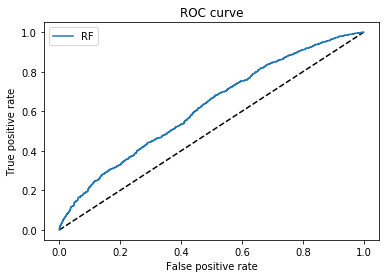

In [88]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

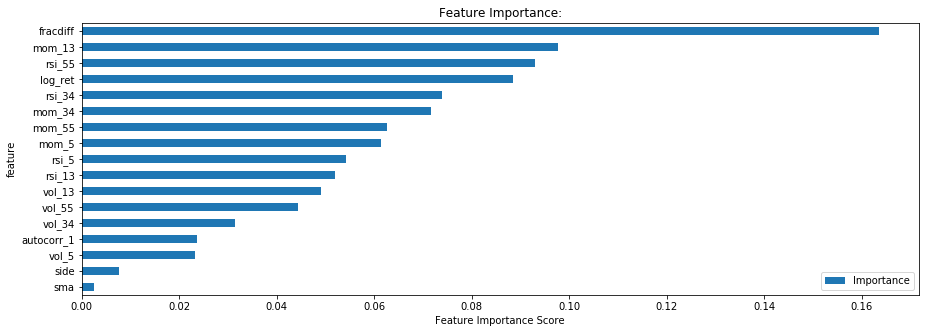

In [86]:
# Feature Importance
title = 'Feature Importance:'
figsize = (15, 5)

feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})    
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.xlabel('Feature Importance Score')
plt.show()

## - Test Performance

             precision    recall  f1-score   support

          0       0.40      0.47      0.43       316
          1       0.51      0.45      0.48       396

avg / total       0.47      0.46      0.46       712

Confusion Matrix
[[147 169]
 [217 179]]

Accuracy
0.45786516853932585


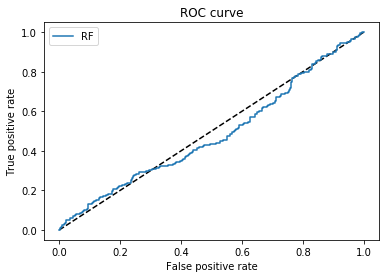

In [98]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Start date,2019-01-14
End date,2019-03-22
Total months,33
,Backtest
Annual return,4.9%
Cumulative returns,14.5%
Annual volatility,18.9%
Sharpe ratio,0.35
Calmar ratio,0.18
Stability,0.21
Max drawdown,-27.3%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,27.32,2019-03-11,2019-03-21,NaT,NaN
1,18.24,2019-02-19,2019-02-28,2019-03-06,12
2,10.98,2019-01-29,2019-01-30,2019-02-08,9
3,9.43,2019-01-16,2019-01-17,2019-01-28,8
4,6.56,2019-02-15,2019-02-15,2019-02-15,1


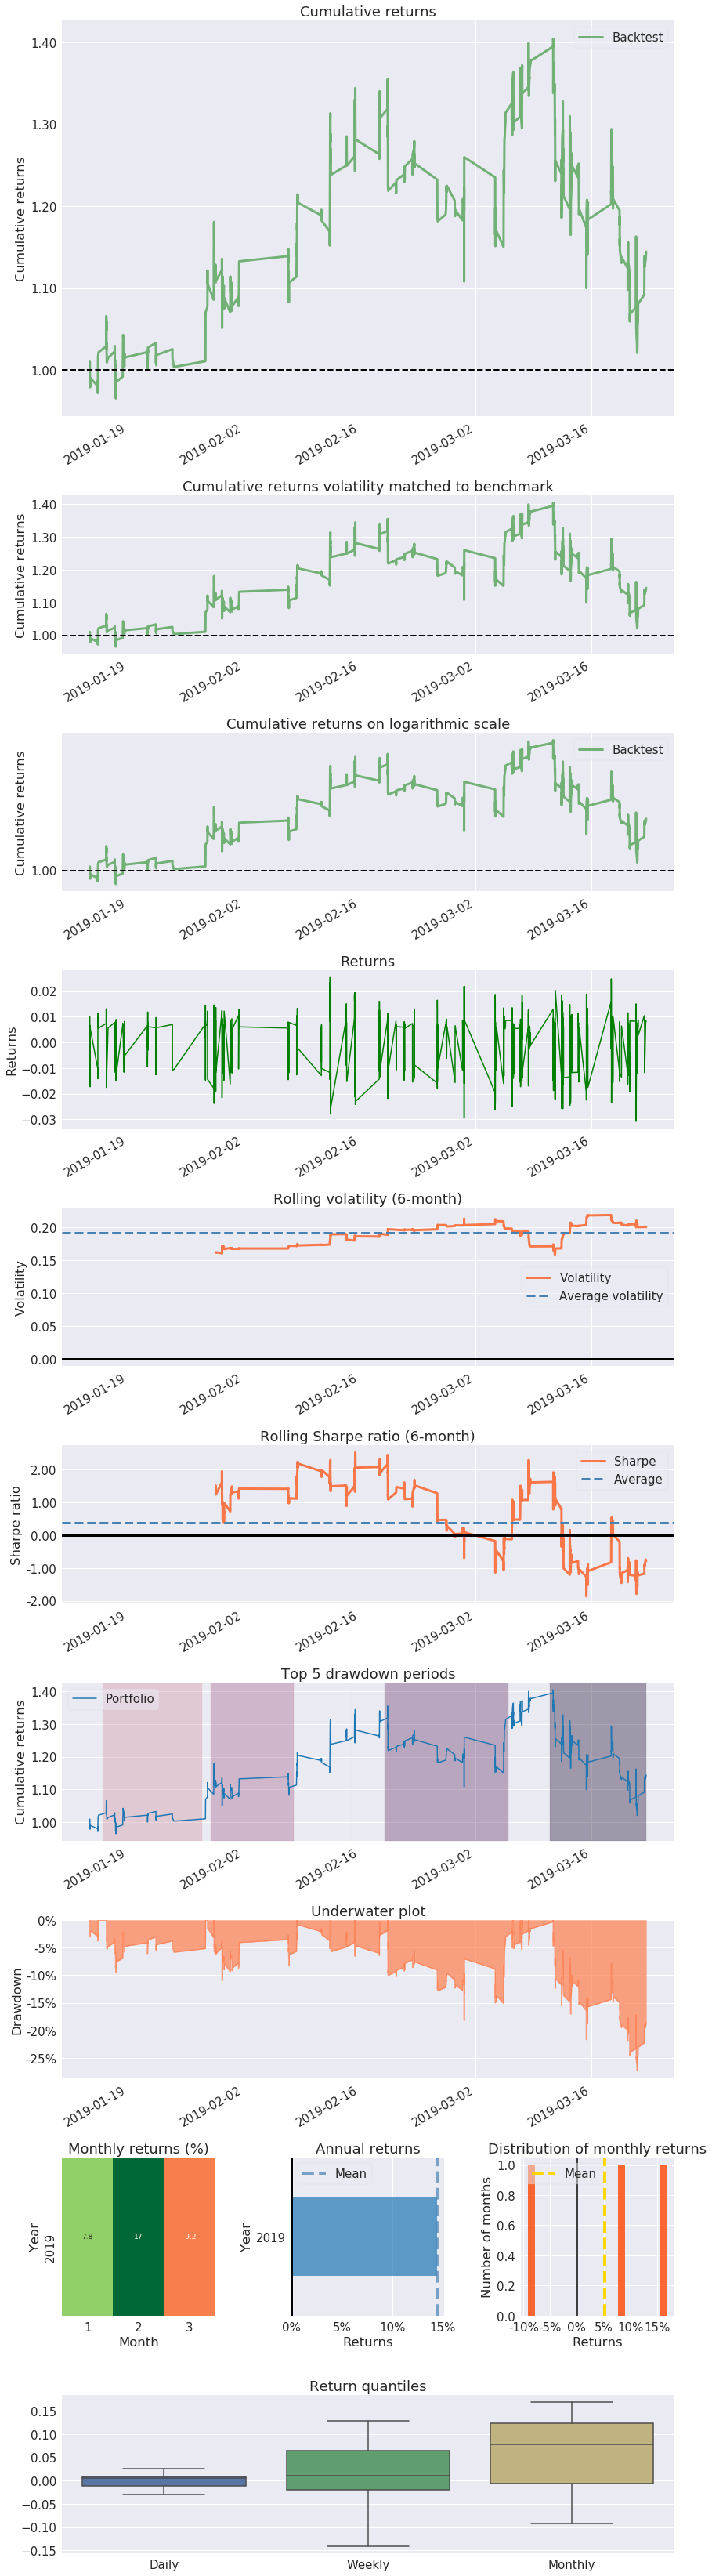

In [99]:
# Primary Model의 결과 값 
test_dates = X_test.index
pf.create_returns_tear_sheet(labels.loc[test_dates, 'ret'], benchmark_rets=None)

Start date,2019-01-14
End date,2019-03-22
Total months,33
,Backtest
Annual return,-16.8%
Cumulative returns,-40.5%
Annual volatility,13.5%
Sharpe ratio,-1.29
Calmar ratio,-0.30
Stability,0.88
Max drawdown,-56.7%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,56.69,2019-01-29,2019-03-14,NaT,NaN
1,7.11,2019-01-16,2019-01-16,2019-01-28,8
2,2.52,2019-01-14,2019-01-15,2019-01-15,1
3,0.00,2019-01-14,2019-01-14,2019-01-14,1
4,0.00,2019-01-14,2019-01-14,2019-01-14,1


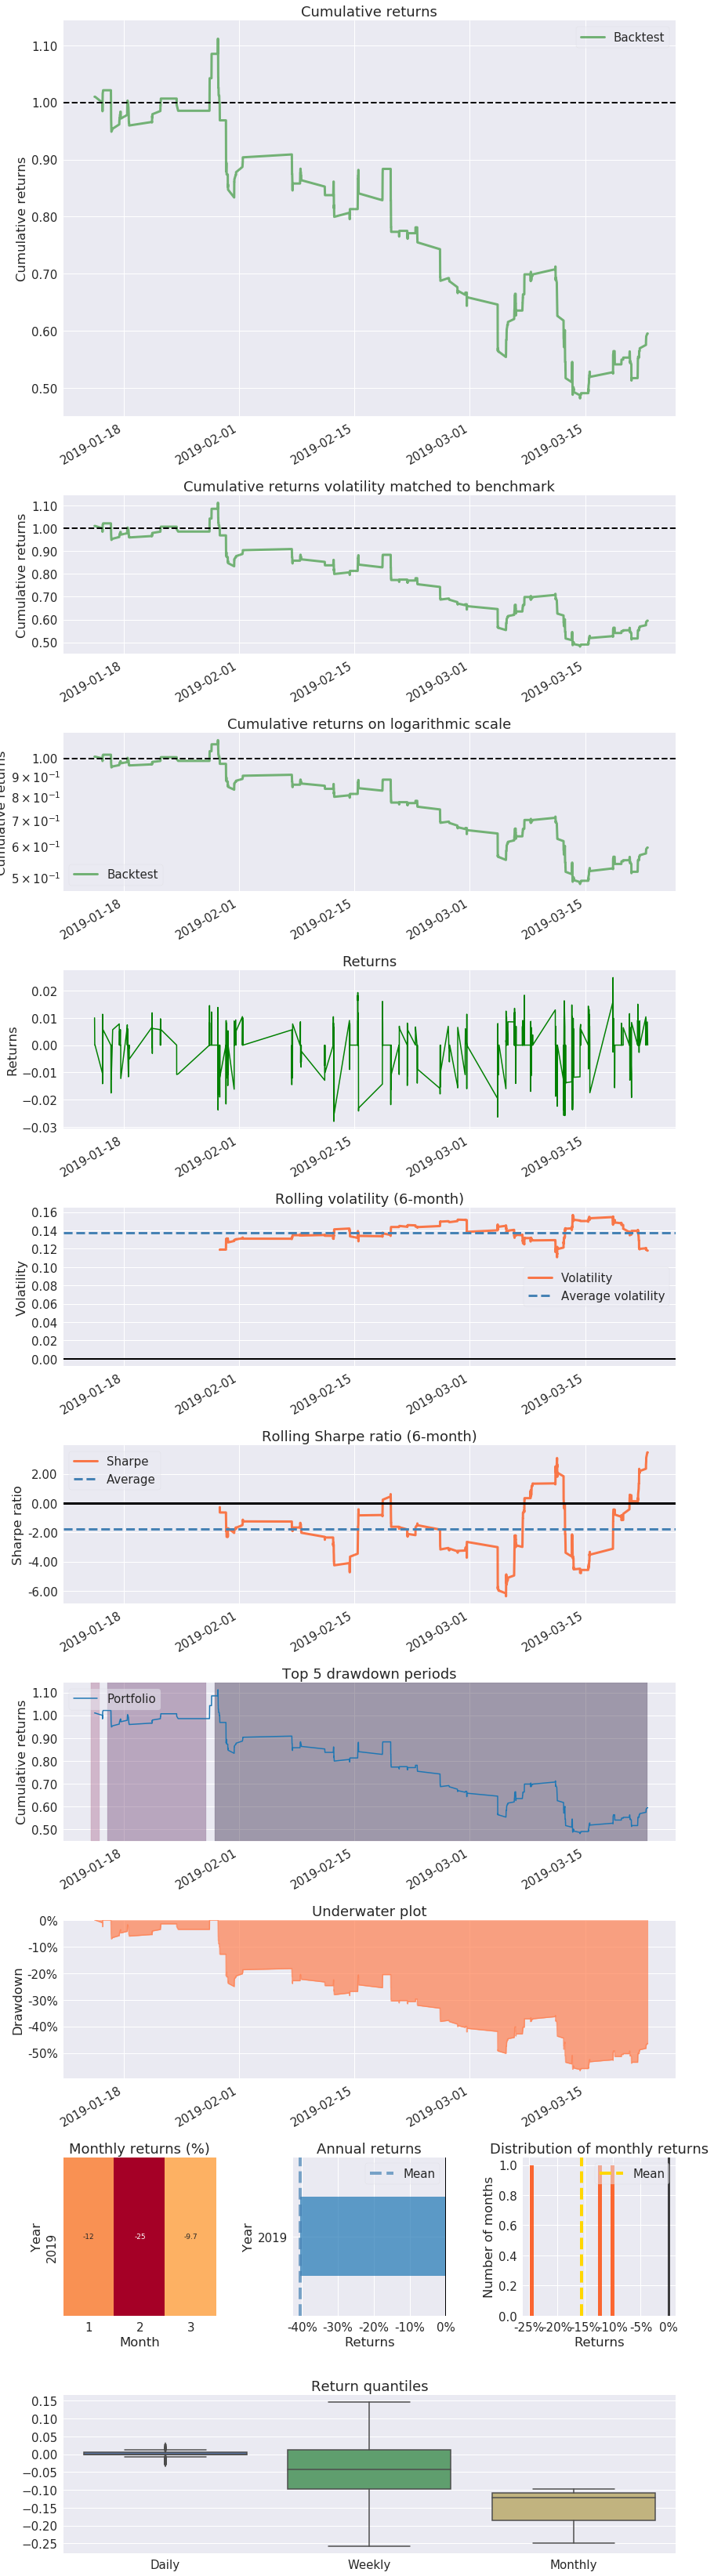

In [100]:
# Meta Model의 결과 값
meta_returns = labels.loc[test_dates, 'ret'] * y_pred
pf.create_returns_tear_sheet(meta_returns, benchmark_rets=None)

## Codes from Chapter 7

## - 7.1 Purging Observations in training set

In [101]:
def getTrainTimes(t1,testTimes):
    """
    Given testTimes, find the times of the training observations
    -t1.index: Time when the observation started
    -t1.value: Time when the observation ended
    -testTimes: Times of testing observations
    """
    trn=t1.copy(deep=True)
    for i,j in testTimes.iteritems():
        df0=trn[(i<=trn.index)&(trn.index<=j)].index # train starts within test
        df1=trn[(i<=trn)&(trn<=j)].index # train ends within test
        df2=trn[(trn.index<=i)&(j<=trn)].index # train envelops test
        trn=trn.drop(df0.union(df1).union(df2))
    return trn

## - 7.2 Embargo on Training Observations

In [103]:
def getEmbargoTimes(times,pctEmbargo):
    # Get embargo time for each bar
    step=int(times.shape[0]*pctEmbargo)
    if step==0:
        mbrg=pd.Series(times,index=times)
    else:
        mbrg=pd.Series(times[step:],index=times[:-step])
        mbrg=mbrg.append(pd.Series(times[-1],index=times[-step:]))
    return mbrg

## - 7.3 Cross-validation class when observation overlap

In [104]:
from sklearn.model_selection._split import _BaseKFold
class PurgedKFold(_BaseKFold):
    """
    Extend KFold class to work with labels that span intervals
    The train is purged of observations overlapping test-label intervals
    Test set is assumed contiguous (shuffle=False), w/o training samples in between
    """
    def __init__(self,n_splits=3,t1=None,pctEmbargo=0.):
        if not isinstance(t1,pd.Series):
            raise ValueError('Label Through Dates must be a pd.Series')
        super(PurgedKFold,self).__init__(n_splits,shuffle=False,random_state=None)
        self.t1=t1
        self.pctEmbargo=pctEmbargo
        
    def split(self,X,y=None,groups=None):
        if (X.index==self.t1.index).sum()!=len(self.t1):
            raise ValueError('X and ThruDateValues must have the same index')
        indices=np.arange(X.shape[0])
        mbrg=int(X.shape[0]*self.pctEmbargo)
        test_starts=[
            (i[0],i[-1]+1) for i in np.array_split(np.arange(X.shape[0]),
                                                   self.n_splits)
        ]
        for i,j in test_starts:
            t0=self.t1.index[i] # start of test set
            test_indices=indices[i:j]
            maxT1Idx=self.t1.index.searchsorted(self.t1[test_indices].max())
            train_indices=self.t1.index.searchsorted(self.t1[self.t1<=t0].index)
            if maxT1Idx<X.shape[0]: # right train ( with embargo)
                train_indices=np.concatenate((train_indices, indices[maxT1Idx+mbrg:]))
            yield train_indices,test_indices

## - 7.4 Using the PurgedKFold Class

In [105]:
def cvScore(clf,X,y,sample_weight,scoring='neg_log_loss',
            t1=None,cv=None,cvGen=None,pctEmbargo=None):
    if scoring not in ['neg_log_loss','accuracy']:
        raise Exception('wrong scoring method.')
    from sklearn.metrics import log_loss,accuracy_score
    idx = pd.IndexSlice
    if cvGen is None:
        cvGen=PurgedKFold(n_splits=cv,t1=t1,pctEmbargo=pctEmbargo) # purged
    score=[]
    for train,test in cvGen.split(X=X):
        fit=clf.fit(X=X.iloc[idx[train],:],y=y.iloc[idx[train]],
                    sample_weight=sample_weight.iloc[idx[train]].values)
        if scoring=='neg_log_loss':
            prob=fit.predict_proba(X.iloc[idx[test],:])
            score_=-log_loss(y.iloc[idx[test]], prob,
                                    sample_weight=sample_weight.iloc[idx[test]].values,
                                    labels=clf.classes_)
        else:
            pred=fit.predict(X.iloc[idx[test],:])
            score_=accuracy_score(y.iloc[idx[test]],pred,
                                  sample_weight=sample_weight.iloc[idx[test]].values)
        score.append(score_)
    return np.array(score)

## Exercises from Chapter 7

## 7.1 
- Why is shuffling a dataset before conducting k-fold CV generally a bad idea in Finance? 
    - Because financial data has memory also known as "predictive information contained in sequence". (Autocorrelation)
- What is the purpose of shuffling?
    - Shuffling is to help the data be more IID.
- Why does shuffling defeat the purpose of k-fold CV in fnancial datasets?
    - When autocorrelated data is shuffled, the information is leaked into the training-dataset and it increases the risks of overfitting.

## 7.2
- Take a pair of matrices (X, y) representing observed features and labels.
- These could be one of the datasets derived from the exercises in chapter 3.
- (a) Derive the performance from a 10-fold CV of an RF classifier on (X, y), without shuffling.
- (b) Derive the performance from a 10-fold CV of an RF classifier on (X, y), with shuffling.
- (c) Why are both results so different?
- (d) How does shuffling leak information?
    - Results are different due to shuffling. 
    - Shuffling places correlated samples into the training set even if the observations are different.
    - This gives the algorithm an opportunity to overfit
    - Also, this is what is responsible for the increased performance in the shuffled version.

In [107]:
from sklearn.model_selection import StratifiedKFold


def crossValPlot(skf,classifier,X_,y_):
    """Code adapted from:
        
    """
    
    X = np.asarray(X_)
    y = np.asarray(y_)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    f,ax = plt.subplots(figsize=(10,7))
    i = 0
    for train, test in skf.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    ax.legend(bbox_to_anchor=(1,1))

#### (a) derive the performance from a 10-fold CV of an RF classifier on (X, y), without "Shuffling"


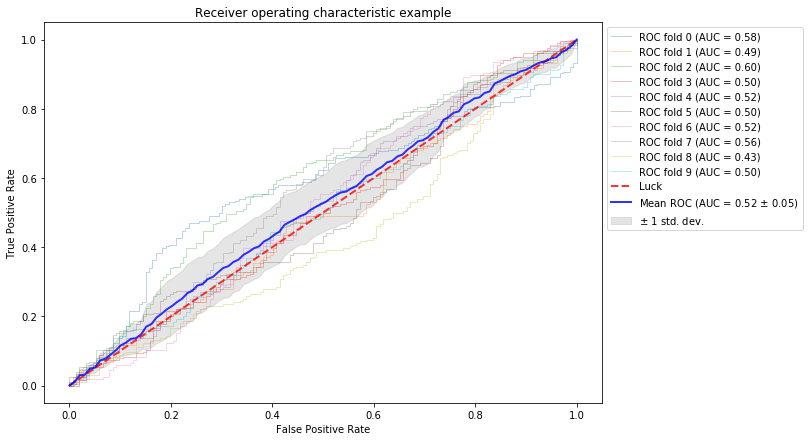

In [108]:
skf = StratifiedKFold(n_splits=10, shuffle=False, random_state=RANDOM_STATE)
classifier = RandomForestClassifier(n_estimators=n_estimator, max_depth=depth, 
                                    criterion='entropy',
                                    class_weight='balanced_subsample',
                                    random_state=RANDOM_STATE)
crossValPlot(skf,classifier,X,y)

#### (b) Derive the performance from a 10-fold CV of an RF classifier on (X, y) with "Shuffling".

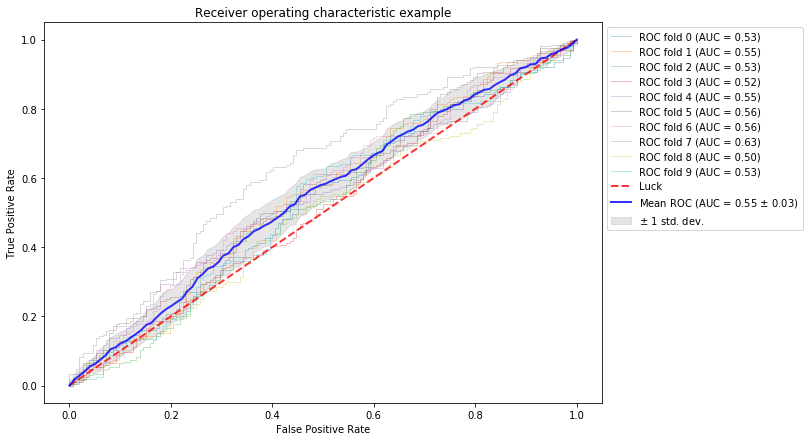

In [109]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
classifier = RandomForestClassifier(n_estimators=n_estimator, max_depth=depth, 
                                    criterion='entropy',
                                    class_weight='balanced_subsample',
                                    random_state=RANDOM_STATE)
crossValPlot(skf,classifier,X,y)

## 7.3
- Take the same pair of matrices (X, y) you used in exercise 2.
- (a) Derive the performance from a 10-fold "purged" CV of an RF on (x,y) with 1% embargo.
- (b) Why is the performance lower?
    - The performance is lowered because redundant samples are minimized.
    - shuffling is removed thereby removing leakage and an additional layer of protection is implemented between the test sets and the following train sets.
    - This is called an embargo which serves to further eliminate leakage between train and test sets.
- (c) Why is this result more realistic?
    - Preventing information leakage results in performance that is closer to out of sample performance where the future is unknowable.

In [111]:
def crossValPlot2(skf,classifier,X,y):
    """Code adapted from:
        
    """
    from itertools import cycle
    from sklearn.metrics import roc_curve, auc
    from scipy import interp
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    idx = pd.IndexSlice
    f,ax = plt.subplots(figsize=(10,7))
    i = 0
    for train, test in skf.split(X, y):
        probas_ = (classifier.fit(X.iloc[idx[train]], y.iloc[idx[train]])
                   .predict_proba(X.iloc[idx[test]]))
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[idx[test]], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    ax.legend(bbox_to_anchor=(1,1))
    
def mpPandasObj(func,pdObj,numThreads=1,mpBatches=1,linMols=True,**kargs):
    '''
    Parallelize jobs, return a dataframe or series
    + func: function to be parallelized. Returns a DataFrame
    + pdObj[0]: Name of argument used to pass the molecule
    + pdObj[1]: List of atoms that will be grouped into molecules
    + kwds: any other argument needed by func
    Example: df1=mpPandasObj(func,('molecule',df0.index),24,**kwds)
    '''
    import pandas as pd
    #if linMols:parts=linParts(len(argList[1]),numThreads*mpBatches)
    #else:parts=nestedParts(len(argList[1]),numThreads*mpBatches)
    if linMols:parts=linParts(len(pdObj[1]),numThreads*mpBatches)
    else:parts=nestedParts(len(pdObj[1]),numThreads*mpBatches)

    jobs=[]
    for i in range(1,len(parts)):
        job={pdObj[0]:pdObj[1][parts[i-1]:parts[i]],'func':func}
        job.update(kargs)
        jobs.append(job)
    if numThreads==1:out=processJobs_(jobs)
    else: out=processJobs(jobs,numThreads=numThreads)
    if isinstance(out[0],pd.DataFrame):df0=pd.DataFrame()
    elif isinstance(out[0],pd.Series):df0=pd.Series()
    else:return out
    for i in out:df0=df0.append(i)
    df0=df0.sort_index()
    return df0

def mpNumCoEvents(closeIdx,t1,molecule):
    '''
    Compute the number of concurrent events per bar.
    +molecule[0] is the date of the first event on which the weight will be computed
    +molecule[-1] is the date of the last event on which the weight will be computed
    Any event that starts before t1[modelcule].max() impacts the count.
    '''
    #1) find events that span the period [molecule[0],molecule[-1]]
    t1=t1.fillna(closeIdx[-1]) # unclosed events still must impact other weights
    t1=t1[t1>=molecule[0]] # events that end at or after molecule[0]
    t1=t1.loc[:t1[molecule].max()] # events that start at or before t1[molecule].max()
    #2) count events spanning a bar
    iloc=closeIdx.searchsorted(np.array([t1.index[0],t1.max()]))
    count=pd.Series(0,index=closeIdx[iloc[0]:iloc[1]+1])
    for tIn,tOut in t1.iteritems():count.loc[tIn:tOut]+=1.
    return count.loc[molecule[0]:t1[molecule].max()]

def linParts(numAtoms,numThreads):
    # partition of atoms with a single loop
    parts=np.linspace(0,numAtoms,min(numThreads,numAtoms)+1)
    parts=np.ceil(parts).astype(int)
    return parts

def processJobs_(jobs):
    # Run jobs sequentially, for debugging
    out=[]
    for job in jobs:
        out_=expandCall(job)
        out.append(out_)
    return out
def expandCall(kargs):
    # Expand the arguments of a callback function, kargs['func']
    func=kargs['func']
    del kargs['func']
    out=func(**kargs)
    return out
def mpSampleW(t1,numCoEvents,close,molecule):
    # Derive sample weight by return attribution
    ret=np.log(close).diff() # log-returns, so that they are additive
    wght=pd.Series(index=molecule)
    for tIn,tOut in t1.loc[wght.index].iteritems():
        wght.loc[tIn]=(ret.loc[tIn:tOut]/numCoEvents.loc[tIn:tOut]).sum()
    return wght.abs()

In [112]:
# uniqueness
cpus = 1
close = raw_data.close
t1 = triple_barrier_events['t1'].loc[X.index]
idx = triple_barrier_events.loc[X.index].index

numCoEvents = mpPandasObj(mpNumCoEvents,('molecule',idx),                         
                              cpus,closeIdx=close.index,t1=t1)
numCoEvents = numCoEvents.loc[~numCoEvents.index.duplicated(keep='last')]
numCoEvents = numCoEvents.reindex(close.index).fillna(0)

sample_weights = pd.DataFrame(index=X.index)
sample_weights['w']=mpPandasObj(mpSampleW,('molecule',idx),cpus,
                         t1=t1, numCoEvents=numCoEvents, close=close)
sample_weights['w']*=sample_weights.shape[0]/sample_weights['w'].sum()
print(sample_weights)

                                   w
2018-09-18 09:39:44.953544  6.955165
2018-09-18 09:51:01.579142  0.014330
2018-09-18 09:58:50.376134  0.567831
2018-09-18 10:00:54.219239  1.724944
2018-09-18 11:07:22.001161  2.078487
2018-09-18 11:25:09.700983  0.445492
2018-09-19 09:02:17.676248  1.121872
2018-09-19 09:04:45.606726  0.195921
2018-09-19 09:06:50.787466  1.111385
2018-09-19 09:10:10.641505  1.048912
2018-09-19 09:11:07.483743  0.842452
2018-09-19 09:16:53.404701  0.129220
2018-09-19 09:28:01.853024  0.375977
2018-09-19 09:37:04.420468  0.661497
2018-09-19 10:05:13.996245  0.974579
2018-09-19 10:18:01.640673  0.613874
2018-09-19 10:21:03.791934  0.307728
2018-09-19 10:30:05.152154  0.390588
2018-09-19 10:35:03.341006  0.160433
2018-09-19 10:56:04.063953  0.480410
2018-09-19 11:12:33.439757  0.513610
2018-09-19 11:54:45.266739  0.454400
2018-09-19 12:12:16.276637  0.360824
2018-09-19 12:46:20.682170  0.373665
2018-09-19 13:01:07.028467  0.429626
2018-09-19 13:18:03.486706  0.765858
2

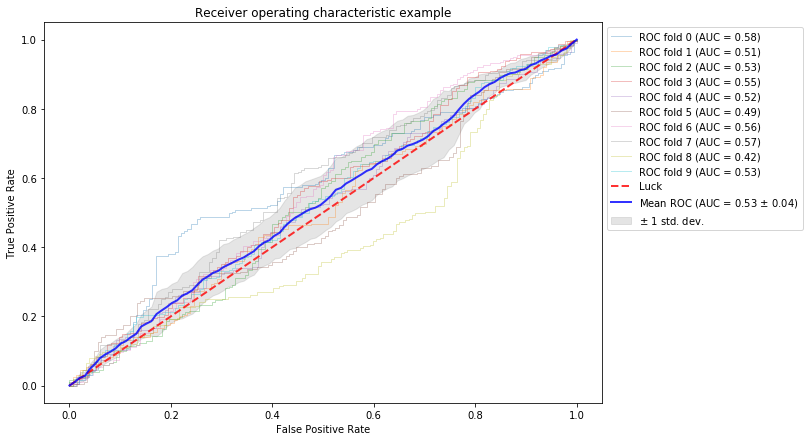

In [113]:
skf = PurgedKFold(n_splits=10,t1=t1,pctEmbargo=0.01)
classifier = RandomForestClassifier(n_estimators=n_estimator, max_depth=depth,
                                    criterion='entropy', 
                                    class_weight='balanced_subsample',
                                    random_state=RANDOM_STATE)
crossValPlot2(skf,classifier,X,y)

In [114]:
# neg_log_loss 
# higher neg_log_loss value => better 
scores = cvScore(classifier,X,y,sample_weights['w'],t1=t1,pctEmbargo=0.01,cv=10)
scores = pd.Series(scores).sort_values()
scores

1   -0.706232
8   -0.696881
5   -0.691685
3   -0.682342
7   -0.670135
0   -0.661651
6   -0.660370
4   -0.660003
2   -0.634166
9   -0.610382
dtype: float64